In [1]:
from __future__ import annotations

import sys
import traceback
from pathlib import Path
from typing import Any, List

import numpy as np
import pandas as pd  # type: ignore[import]

In [2]:
PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "src").is_dir():
    PROJECT_ROOT = PROJECT_ROOT.parent
SRC_ROOT = PROJECT_ROOT / "src"
DATA_ROOT = PROJECT_ROOT / "data" / "processed"

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"Using project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_ROOT}")

Using project root: D:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning
Data directory: D:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning\data\processed


In [3]:
from src.Bayesian_state.utils.load_config import MODEL_STRUCT  # type: ignore[import]
# from src.Bayesian_state.problems import StateModel  # type: ignore[import]
# Use local import to avoid circular dependency if needed, or rely on the fix in state_grid_optimizer.py
from src.Bayesian_state.problems import StateModel

print(f"Available model structures: {list(MODEL_STRUCT.keys())}")

INFO:cat-learning:logger is running normally.


D:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning\logs\Run_20251218_024404.log
{'base_model': {'modules': {'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {}}}, 'agenda': ['likelihood_mod', '__self__']}, 'default_model': {'modules': {}, 'agenda': ['__self__']}, 'm_model': {'modules': {'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.8, 'gamma': 0.8}}}, 'agenda': ['likelihood_mod', 'memory_mod']}, 'pmh_model': {'modules': {'perception_mod': {'class': 'src.Bayesian_state.problems.modules.perception.PerceptionModule'}, 'hypo_transitions_mod': {'class': 'src.Bayesian_state.problems.modules.hypo_transitions.DynamicHypothesisModule', 'kwargs': {'strategies': 'original_strategies', 'init_num': 8, 'beta': 10.0}}, 'likelihood_mod': {'class': 

In [4]:
def build_subject_dataset(subject_id: int) -> tuple[np.ndarray, np.ndarray, np.ndarray, int]:
    """Load Task2 data and return arrays for a single subject."""
    task2_path = DATA_ROOT / "Task2_processed.csv"
    if not task2_path.exists():
        raise FileNotFoundError(f"Missing processed dataset: {task2_path}")

    learning_data = pd.read_csv(task2_path)
    subject_data = learning_data[learning_data["iSub"] == subject_id]
    if subject_data.empty:
        raise ValueError(f"Subject {subject_id} not found in Task2 dataset")

    condition = int(subject_data["condition"].iloc[0])
    stimulus = subject_data[["feature1", "feature2", "feature3", "feature4"]].to_numpy(dtype=float)
    choices = subject_data["choice"].to_numpy(dtype=float)
    feedback = subject_data["feedback"].to_numpy(dtype=float)

    return stimulus, choices, feedback, condition


def make_trial_sequence(stimulus: np.ndarray, choices: np.ndarray, feedback: np.ndarray, max_trials: int = 20) -> List[List[Any]]:
    """Assemble the per-trial list expected by StateModel.fit_step_by_step."""
    usable = min(len(stimulus), max_trials)
    trials: List[List[Any]] = []
    for idx in range(usable):
        trial: List[Any] = [stimulus[idx], int(choices[idx]), float(feedback[idx])]
        trials.append(trial)
    return trials

In [5]:
subject_id = 23

try:
    stimulus, choices, feedback, condition = build_subject_dataset(subject_id)
except Exception as exc:  # noqa: BLE001
    print("Dataset preparation failed:", exc)
    traceback.print_exc()
    raise

print(f"Loaded subject {subject_id} with {len(stimulus)} trials (condition {condition}).")
print("First stimulus row:", stimulus[0])
print("Choice / feedback samples:", choices[:3], feedback[:3])
print("Condition", condition)

Loaded subject 23 with 505 trials (condition 2).
First stimulus row: [0.40074351 0.34284698 0.54912401 0.40210323]
Choice / feedback samples: [1. 3. 3.] [1. 0. 0.]
Condition 2


In [6]:
from copy import deepcopy

model_choice = "pmh_model"


engine_config = deepcopy(MODEL_STRUCT.get(model_choice))

if engine_config is None:
    raise KeyError(f"{model_choice} configuration not found in MODEL_STRUCT")

# DEBUG CONFIG
hypo_debug = True
if "modules" in engine_config and "hypo_transitions_mod" in engine_config["modules"]:
    engine_config["modules"]["hypo_transitions_mod"]["kwargs"]['hypothesis_debug'] = hypo_debug

try:
    model = StateModel(
        engine_config,
        condition=condition,
        subject_id=subject_id,
        processed_data_dir=DATA_ROOT,
    )
except Exception as exc:
    print("StateModel construction failed:", exc)
    traceback.print_exc()
    raise

print("StateModel initialised successfully.")

INFO:cat-learning:  - Module 'perception_mod' registered as 'self.perception_mod'.
INFO:cat-learning:  - Module 'hypo_transitions_mod' registered as 'self.hypo_transitions_mod'.
INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
D:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning\src\Bayesian_state\problems\modules\memory.py:223: RuntimeWarning: divide by zero encountered in log
  return np.log(clipped)
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


Loading similarity matrix from disk: D:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning\src\Bayesian_state\problems\cache\similarity_matrix_d4_c4.npy
{'perception_mod': {'class': 'src.Bayesian_state.problems.modules.perception.PerceptionModule', 'kwargs': {'mean': [-0.004597977335402445, 0.001069761644831074, 0.01209565264353419, -0.002280659543294282], 'std': [0.019375206357766673, 0.042789558081736574, 0.04508111106835397, 0.04980489158506709], 'subject_id': 23}}, 'hypo_transitions_mod': {'class': 'src.Bayesian_state.problems.modules.hypo_transitions.DynamicHypothesisModule', 'kwargs': {'strategies': 'original_strategies', 'init_num': 8, 'beta': 10.0, 'hypothesis_debug': True}}, 'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 10.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.3, 'gamma': 0.9}}}
name: perception_mod mod_kwargs: {'mean': 

In [7]:
trial_sequence = make_trial_sequence(stimulus, choices, feedback, max_trials=100000)
print(f"Prepared {len(trial_sequence)} trials for inference.")
print("Example trial:", trial_sequence[0])

Prepared 505 trials for inference.
Example trial: [array([0.40074351, 0.34284698, 0.54912401, 0.40210323]), 1, 1.0]


In [8]:
try:
    posterior_log, prior_log = model.fit_step_by_step(trial_sequence)
except Exception as exc:
    print("fit_step_by_step raised an exception:", exc)
    traceback.print_exc()
    raise


Transition Debug: Max Posterior = 0.0086
Transition Debug: Beta = 10.0
  Strategy top_posterior: amount=1
    Selected: [103]
  Strategy random: amount=6
    Selected: [88, 0, 56, 59, 47, 10]
  Strategy ksimilar_centers: amount=1
    Selected: [38]
DynamicHypothesis: 8 -> 8 hypos
  Hypothesis 42 is INACTIVE. Post: 0.0086
Transition Debug: Max Posterior = 0.2149
Transition Debug: Beta = 10.0
  Strategy top_posterior: amount=1
    Selected: [0]
  Strategy random: amount=6
    Selected: [90, 58, 88, 10, 57, 5]
  Strategy ksimilar_centers: amount=1
    Selected: [51]
DynamicHypothesis: 8 -> 8 hypos
  Hypothesis 42 is INACTIVE. Post: 0.0000
Transition Debug: Max Posterior = 0.2364
Transition Debug: Beta = 10.0
  Strategy top_posterior: amount=1
    Selected: [0]
  Strategy random: amount=6
    Selected: [58, 12, 9, 93, 111, 46]
  Strategy ksimilar_centers: amount=1
    Selected: [45]
DynamicHypothesis: 8 -> 8 hypos
  Hypothesis 42 is INACTIVE. Post: 0.0000
Transition Debug: Max Posterior = 

In [9]:
# 打印 posterior 最大的 5 个 hypo index 以及他们的 similarity
post_sum_hypo = np.sum(posterior_log, axis=0)
top5_indices = np.argsort(post_sum_hypo)[-5:][::-1]
print(top5_indices)
# similarity
similarity_matrix = model.engine.partition.similarity_matrix
similarity_matrix_5 = similarity_matrix[top5_indices][:, top5_indices]
similarity_matrix_5

[ 42  66 106  48  55]


array([[1.     , 0.67611, 0.75935, 0.68776, 0.68988],
       [0.67611, 1.     , 0.59276, 0.55817, 0.55581],
       [0.75935, 0.59276, 1.     , 0.55666, 0.55931],
       [0.68776, 0.55817, 0.55666, 1.     , 0.42851],
       [0.68988, 0.55581, 0.55931, 0.42851, 1.     ]])

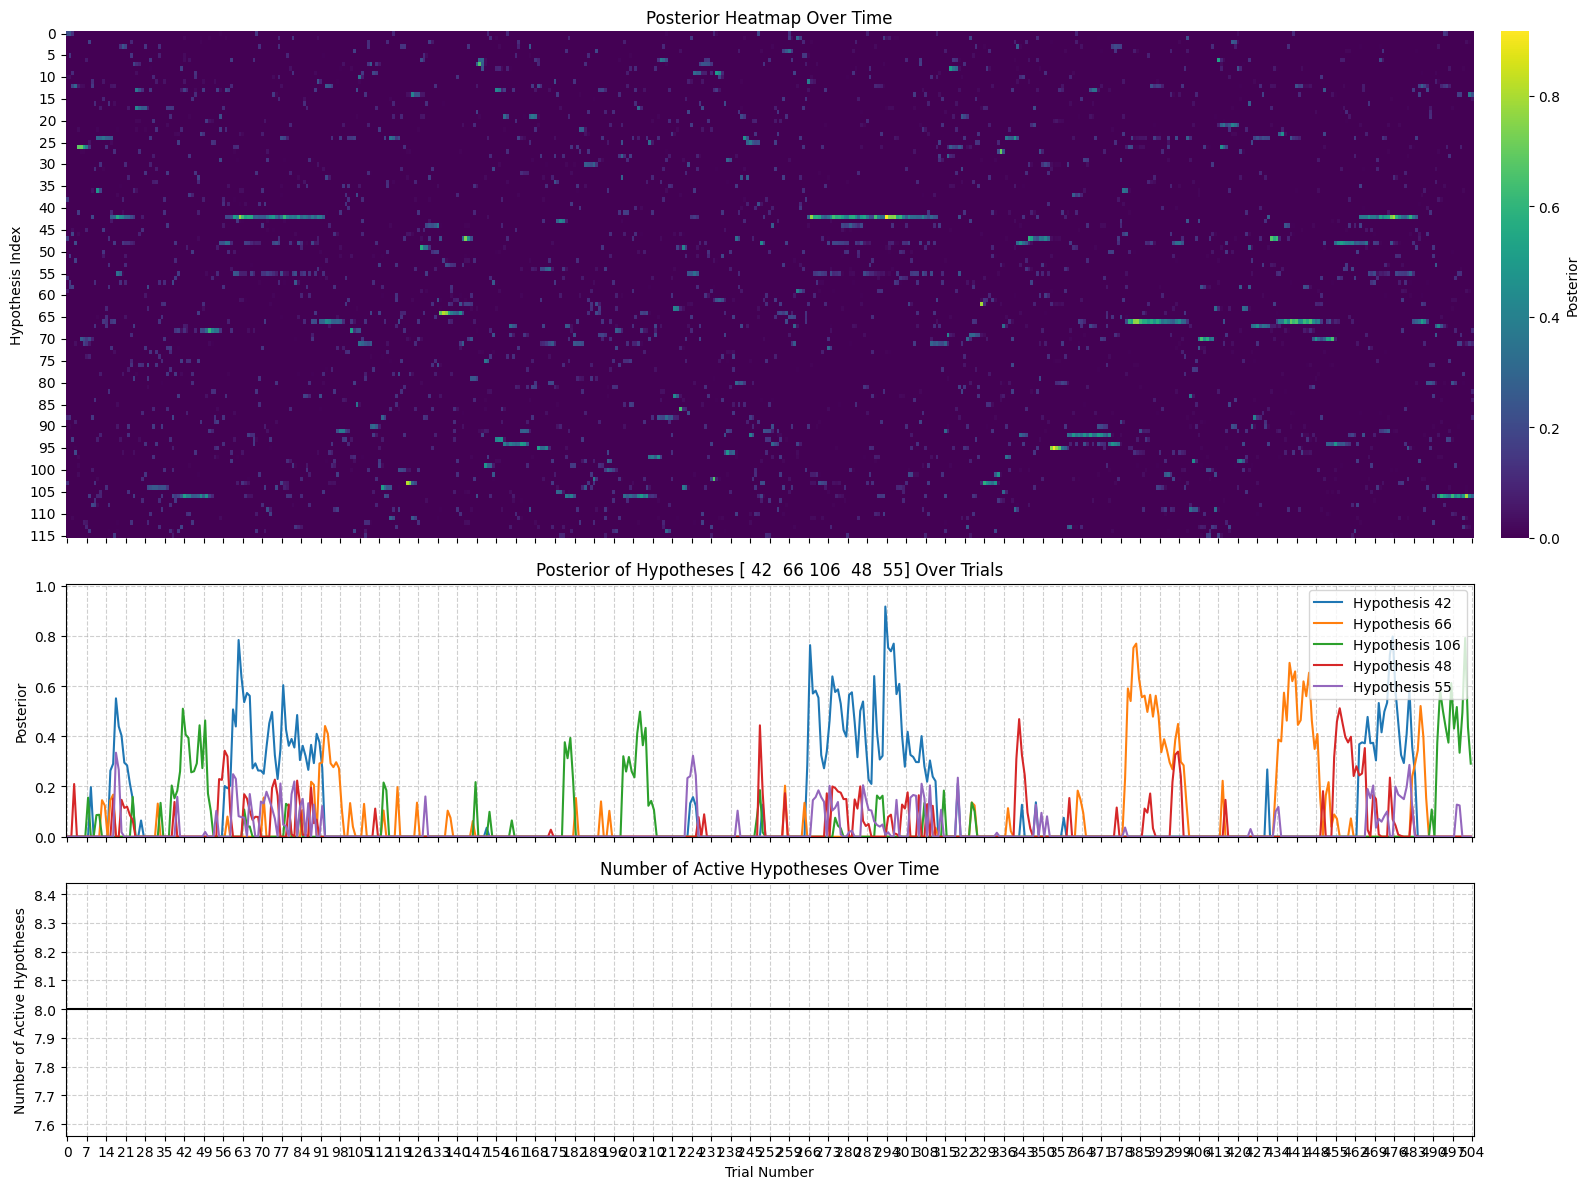

In [10]:
# 画图

import matplotlib.pyplot as plt  # type: ignore[import]
import seaborn as sns  # type: ignore[import]

# 准备数据
posterior_array = np.array(posterior_log).T
n_steps = posterior_array.shape[1]
trials = np.arange(n_steps)
hypo_indices = top5_indices
active_hypos_num_list = [np.argwhere(posterior_log[i]).shape[0] for i in range(len(posterior_log))]

# 创建 3行2列 的子图布局
# 第1列用于画主图，第2列用于画 colorbar（只在第1行使用，下面两行留空）
# width_ratios=[50, 1] 保证 colorbar 不会太宽
fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex='col', 
                         gridspec_kw={'height_ratios': [2, 1, 1], 'width_ratios': [50, 1]})

# 分配 axes
ax_heatmap = axes[0, 0]
ax_cbar = axes[0, 1]
ax_line = axes[1, 0]
ax_count = axes[2, 0]

# 隐藏第2、3行的第2列（不需要 colorbar 的位置）
axes[1, 1].axis('off')
axes[2, 1].axis('off')

# 1. Heatmap
# 使用 cbar_ax 参数将 colorbar 绘制在指定的 ax_cbar 中，这样 ax_heatmap 就不会被压缩，能和下面的图对齐
sns.heatmap(posterior_array, cmap="viridis", ax=ax_heatmap, cbar_ax=ax_cbar, cbar_kws={'label': 'Posterior'})
ax_heatmap.set_ylabel("Hypothesis Index")
ax_heatmap.set_title("Posterior Heatmap Over Time")

# 2. Line plot for top hypotheses
max_post_overall = 0
for hypo_index in hypo_indices:
    hypo_posterior_over_time = [posterior[hypo_index] for posterior in posterior_log]
    max_post = max(hypo_posterior_over_time)
    if max_post > max_post_overall:
        max_post_overall = max_post
    ax_line.plot(trials, hypo_posterior_over_time, linestyle='-', label=f'Hypothesis {hypo_index}')

ax_line.set_ylabel('Posterior')
ax_line.set_ylim(0, max_post_overall * 1.1)
ax_line.grid(True, linestyle='--', alpha=0.6)
ax_line.legend(loc='upper right')
ax_line.set_title(f'Posterior of Hypotheses {hypo_indices} Over Trials')

# 3. Active hypotheses count
ax_count.plot(trials, active_hypos_num_list, color='black')
ax_count.set_ylabel('Number of Active Hypotheses')
ax_count.set_xlabel('Trial Number')
ax_count.grid(True, linestyle='--', alpha=0.6)
ax_count.set_title('Number of Active Hypotheses Over Time')

# 调整布局
plt.tight_layout()
plt.show()

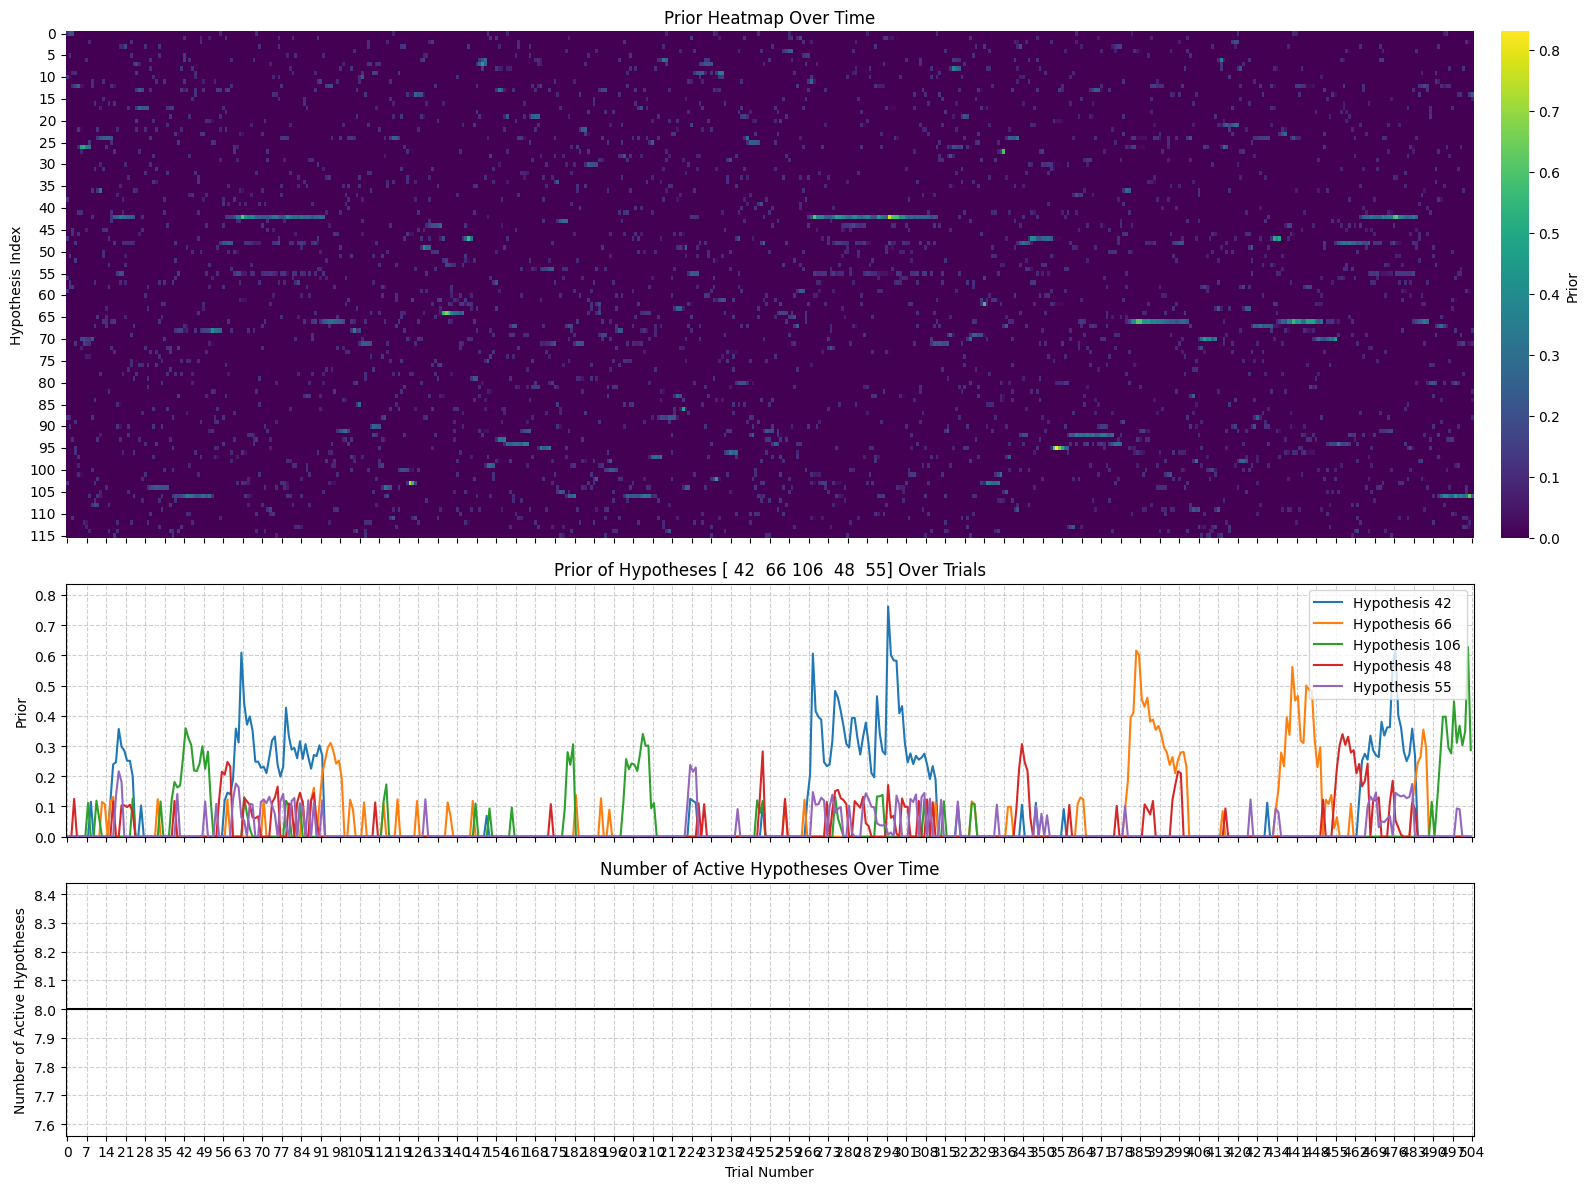

In [11]:
# 仿照 posterior，也画出 prior 的图
prior_array = np.array(prior_log).T
n_steps = prior_array.shape[1]
# 创建 3行2列 的子图布局
# 第1列用于画主图，第2列用于画 colorbar（只在第1行使用，下面两行留空）
# width_ratios=[50, 1] 保证 colorbar 不会太宽

fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex='col', 
                         gridspec_kw={'height_ratios': [2, 1, 1], 'width_ratios': [50, 1]})
# 分配 axes
ax_heatmap = axes[0, 0]
ax_cbar = axes[0, 1]
ax_line = axes[1, 0]
ax_count = axes[2, 0]
# 隐藏第2、3行的第2列（不需要 colorbar 的位置）
axes[1, 1].axis('off')
axes[2, 1].axis('off')
# 1. Heatmap
sns.heatmap(prior_array, cmap="viridis", ax=ax_heatmap, cbar_ax=ax_cbar, cbar_kws={'label': 'Prior'})
ax_heatmap.set_ylabel("Hypothesis Index")
ax_heatmap.set_title("Prior Heatmap Over Time")
# 2. Line plot for top hypotheses
max_prior_overall = 0
for hypo_index in hypo_indices:
    hypo_prior_over_time = [prior[hypo_index] for prior in prior_log]
    max_prior = max(hypo_prior_over_time)
    if max_prior > max_prior_overall:
        max_prior_overall = max_prior
    ax_line.plot(trials, hypo_prior_over_time, linestyle='-', label=f'Hypothesis {hypo_index}')
ax_line.set_ylabel('Prior')
ax_line.set_ylim(0, max_prior_overall * 1.1)
ax_line.grid(True, linestyle='--', alpha=0.6)
ax_line.legend(loc='upper right')
ax_line.set_title(f'Prior of Hypotheses {hypo_indices} Over Trials')
# 3. Active hypotheses count
ax_count.plot(trials, active_hypos_num_list, color='black')
ax_count.set_ylabel('Number of Active Hypotheses')
ax_count.set_xlabel('Trial Number')
ax_count.grid(True, linestyle='--', alpha=0.6)
ax_count.set_title('Number of Active Hypotheses Over Time')
# 调整布局
plt.tight_layout()
plt.show()

